In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_absolute_error, classification_report

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Model

- Starting point is to model the number of goals in a game by team 1 and team 2 using 2 Poisson distributions:</br>
$y_{g1}$ | $\theta_{g1}$ ~ Poisson($\theta_{g1}$)</br>
$y_{g2}$ | $\theta_{g2}$ ~ Poisson($\theta_{g2}$)</br>
where $\theta_{gi}$ represents the scoring intensity in the $g^{th}$ game</br>
</br>
- $\theta$ is modeled assuming log-linear random effect model:</br>
$log\theta_{g1}$ = $att_{1(g)}$ + $def_{2(g)}$ + $home_advantage$</br>
$log\theta_{g2}$ = $att_{2(g)}$ + $def_{1(g)}$</br>
This formulation is slightly different from the commonly used one with home effect as worldcup has only very limited home effect in data</br>
</br>
- Each of the team specific effects are modeled as exchangeable from a common distribution:</br>
$att_{t}$ ~ Normal($\mu_{att}$, $\tau_{att}$)</br>
$def_{t}$ ~ Normal($\mu_{def}$, $\tau_{def}$)</br>
sum-to-zero constraint is used to impose indentifiability</br>
</br>
- $\mu_{att}$, $\tau_{att}$, $\mu_{def}$, $\tau_{def}$ are modelled independently using flat prior distribution:</br>
$\mu_{att}$ ~ Normal(0, 0.0001)</br>
$\tau_{att}$ ~ Gamma(0.1, 0.1)</br>
$\mu_{def}$ ~ Normal(0, 0.0001)</br>
$\tau_{def}$ ~ Gamma(0.1, 0.1)</br>

### Data
- NFL 2022 so far had 276 games

In [6]:
nfl_2022 = pd.read_csv("nfl-2022-UTC.csv")
remaining_games = nfl_2022[nfl_2022['Result'].isna()]
remaining_games

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result
255,241,17,03/01/2023 01:30,Paycor Stadium,Cincinnati Bengals,Buffalo Bills,NaN
277,278,Wild Card Round,17/01/2023 01:15,Raymond James Stadium,Tampa Bay Buccaneers,Dallas Cowboys,NaN


In [7]:
nfl_2022 = nfl_2022.dropna()
nfl = pd.concat([nfl_2022],axis = 0)

nfl["home_team_score"] = nfl["Result"].apply(lambda x: x.split(" - ")[0])
nfl["away_team_score"] = nfl["Result"].apply(lambda x: x.split(" - ")[1])
nfl = nfl.rename(
    columns = {
        "Home Team":"home_team",
        "Away Team":"away_team",
        "home_team_score":"yg1",
        "away_team_score":"yg2",
    }
)

nfl = nfl[["Date", "home_team", "away_team", "yg1", "yg2"]]
nfl

,Date,home_team,away_team,yg1,yg2
0,09/09/2022 00:20,Los Angeles Rams,Buffalo Bills,10,31
1,11/09/2022 17:00,Atlanta Falcons,New Orleans Saints,26,27
2,11/09/2022 17:00,Carolina Panthers,Cleveland Browns,24,26
3,11/09/2022 17:00,Chicago Bears,San Francisco 49ers,19,10
4,11/09/2022 17:00,Cincinnati Bengals,Pittsburgh Steelers,20,23
...,...,...,...,...,...
272,14/01/2023 21:30,San Francisco 49ers,Seattle Seahawks,41,23
273,15/01/2023 01:15,Jacksonville Jaguars,Los Angeles Chargers,31,30
274,15/01/2023 18:00,Buffalo Bills,Miami Dolphins,34,31
275,15/01/2023 21:30,Minnesota Vikings,New York Giants,24,31


In [ ]:
fig, axes  = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,6))
nfl['yg1'] = nfl['yg1'].astype(int)
nfl['yg2'] = nfl['yg2'].astype(int)
allgames_home = nfl.groupby(['home_team']).sum().rename(columns = {'yg1':'winning','yg2':'losing'})
allgames_home.index.name = None
allgames_home[['winning','losing']].plot.bar(ax = axes[0])

allgames_away =  nfl.groupby(['away_team']).sum().rename(columns = {'yg1':'losing','yg2':'winning'})
allgames_away.index.name = None
allgames_away[['winning','losing']].plot.bar(ax = axes[1])
plt.show()

In [15]:
nfl[(nfl['home_team'] == "San Francisco 49ers") | (nfl['away_team'] == "San Francisco 49ers")]

,Date,home_team,away_team,yg1,yg2
3,11/09/2022 17:00,Chicago Bears,San Francisco 49ers,19,10
25,18/09/2022 20:05,San Francisco 49ers,Seattle Seahawks,27,7
46,26/09/2022 00:20,Denver Broncos,San Francisco 49ers,11,10
63,04/10/2022 00:15,San Francisco 49ers,Los Angeles Rams,24,9
75,09/10/2022 20:05,Carolina Panthers,San Francisco 49ers,15,37
81,16/10/2022 17:00,Atlanta Falcons,San Francisco 49ers,28,14
105,23/10/2022 20:25,San Francisco 49ers,Kansas City Chiefs,23,44
119,30/10/2022 20:25,Los Angeles Rams,San Francisco 49ers,14,31
148,14/11/2022 01:20,San Francisco 49ers,Los Angeles Chargers,22,16
163,22/11/2022 01:15,Arizona Cardinals,San Francisco 49ers,10,38


In [17]:
team_id_map = {team: idx for idx, team in enumerate(nfl["home_team"].unique())}
nfl['g1'] = nfl["home_team"].apply(lambda x: team_id_map[x])
nfl['g2'] = nfl["away_team"].apply(lambda x: team_id_map[x])
n_teams = max(team_id_map.values()) + 1
team_id_map

{'Los Angeles Rams': 0,
 'Atlanta Falcons': 1,
 'Carolina Panthers': 2,
 'Chicago Bears': 3,
 'Cincinnati Bengals': 4,
 'Detroit Lions': 5,
 'Houston Texans': 6,
 'Miami Dolphins': 7,
 'New York Jets': 8,
 'Washington Commanders': 9,
 'Tennessee Titans': 10,
 'Arizona Cardinals': 11,
 'Los Angeles Chargers': 12,
 'Minnesota Vikings': 13,
 'Dallas Cowboys': 14,
 'Seattle Seahawks': 15,
 'Kansas City Chiefs': 16,
 'Baltimore Ravens': 17,
 'Cleveland Browns': 18,
 'Jacksonville Jaguars': 19,
 'New Orleans Saints': 20,
 'New York Giants': 21,
 'Pittsburgh Steelers': 22,
 'San Francisco 49ers': 23,
 'Denver Broncos': 24,
 'Las Vegas Raiders': 25,
 'Green Bay Packers': 26,
 'Buffalo Bills': 27,
 'Philadelphia Eagles': 28,
 'Indianapolis Colts': 29,
 'New England Patriots': 30,
 'Tampa Bay Buccaneers': 31}

In [18]:
train, test = train_test_split(nfl, test_size=0.3, random_state=42)

In [19]:
home_team_obs = train["yg1"].values.astype(int)
away_team_obs = train["yg2"].values.astype(int)
home_team = train["g1"].values
away_team = train["g2"].values

In [20]:
with pm.Model() as model:

    # home advantage
    home = pm.Flat("home")
    
    # attack
    tau_att = pm.Gamma("tau_att", 0.1, 0.1)
    atts_star = pm.Normal("atts_star", mu=0, tau=tau_att, shape=n_teams)

    # defence
    tau_def = pm.Gamma("tau_def", 0.1, 0.1)
    def_star = pm.Normal("def_star", mu=0, tau=tau_def, shape=n_teams)

    # sum zero
    atts = pm.Deterministic("atts", atts_star - tt.mean(atts_star))
    defs = pm.Deterministic("defs", def_star - tt.mean(def_star))

    # theta
    home_team_theta = tt.exp(home + atts[home_team] + defs[away_team])
    away_team_theta = tt.exp(atts[away_team] + defs[home_team])

    # goal expectation
    home_team_points = pm.Poisson("home_team_score", mu=home_team_theta, observed=home_team_obs)
    away_team_points = pm.Poisson("away_team_score", mu=away_team_theta, observed=away_team_obs)

In [21]:
with model:
    trace = pm.sample(2000, tune=1000, cores=6, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Lisa\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Lisa\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [def_star, tau_def, atts_star, tau_att, home]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 1249 seconds.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The number of effective samples is smaller than 10% for some parameters.


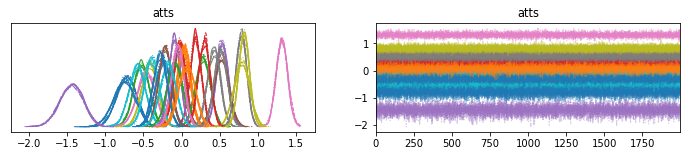

In [23]:
with model:
    pm.plot_trace(trace, var_names=["atts"])

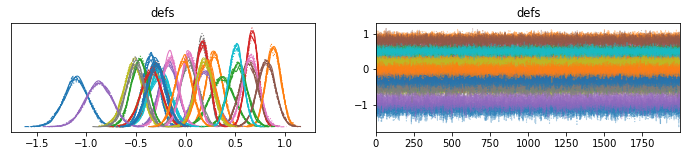

In [24]:
with model:
    pm.plot_trace(trace, var_names=["defs"])

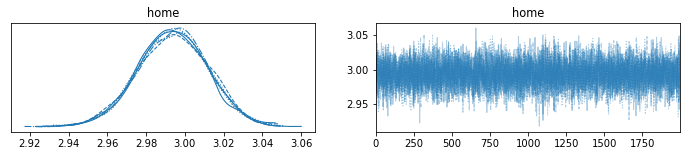

In [25]:
with model:
    pm.plot_trace(trace, var_names=["home"])

In [26]:
teams_unique = [0] * n_teams
for ele in team_id_map.keys():
    teams_unique[team_id_map[ele]] = ele

atts = pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])
atts['median'] = np.quantile(trace["atts"], 0.5, axis=0)
atts['lower'] = atts['median'] - atts['lower_hdi']
atts['upper'] = atts['upper_hdi'] - atts['median']
atts.index = teams_unique

atts = atts[['median','lower_hdi','upper_hdi','lower','upper']]
atts = atts.sort_values('median')

C:\Users\Lisa\AppData\Local\Temp\ipykernel_13492\3000531312.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  atts = pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])


In [27]:
defs = pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])
defs['median'] = np.quantile(trace["defs"], 0.5, axis=0)
defs['lower'] = defs['median'] - defs['lower_hdi']
defs['upper'] = defs['upper_hdi'] - defs['median']
defs.index = teams_unique

defs = defs[['median','lower_hdi','upper_hdi','lower','upper']]
defs = defs.sort_values('median', ascending = False)

C:\Users\Lisa\AppData\Local\Temp\ipykernel_13492\3694678829.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  defs = pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])


In [28]:
pd.concat([atts[['median','lower_hdi','upper_hdi']],
           defs[['median','lower_hdi','upper_hdi']]],
          keys = ['atts','defs'],
          axis = 1).sort_index()

atts                          defs            \
                         median lower_hdi upper_hdi    median lower_hdi   
Arizona Cardinals      0.038618 -0.120195  0.190206  0.883688  0.745019   
Atlanta Falcons       -0.037001 -0.188788  0.104682  0.286902  0.132962   
Baltimore Ravens       0.423127  0.262703  0.580914  0.034163 -0.145915   
Buffalo Bills          0.509580  0.359261  0.666854 -0.504054 -0.686005   
Carolina Panthers     -0.526419 -0.716280 -0.326962  0.364918  0.137160   
Chicago Bears         -0.022504 -0.175531  0.119321  0.669643  0.550957   
Cincinnati Bengals     0.531715  0.391247  0.683500 -0.174470 -0.346808   
Cleveland Browns       0.788068  0.604029  0.986831 -0.529443 -0.708141   
Dallas Cowboys        -0.094157 -0.228542  0.051955  0.190313 -0.005769   
Denver Broncos        -1.438273 -1.731662 -1.160727 -0.875856 -1.126186   
Detroit Lions         -0.047042 -0.208996  0.120800  0.635144  0.464962   
Green Bay Packers     -0.052411 -0.202783  0.100591  0.032601 -0.116519   
Houston Texans        -0.461354 -0.688672 -0.231772  0.656064  0.489777   
Indianapolis Colts    -0.176462 -0.377516  0.014741  0.507082  0.366653   
Jacksonville Jaguars  -0.391686 -0.573207 -0.211139 -0.264658 -0.489687   
Kansas City Chiefs     1.311996  1.165303  1.446999 -0.159084 -0.312593   
Las Vegas Raiders     -0.217057 -0.377227 -0.072903  0.811164  0.637180   
Los Angeles Chargers   0.280167  0.108894  0.465109  0.522904  0.342070   
Los Angeles Rams      -0.718090 -0.961394 -0.476674 -0.352028 -0.508205   
Miami Dolphins         0.782517  0.653370  0.913056  0.166452  0.038744   
Minnesota Vikings      0.183181  0.048307  0.326475  0.170219  0.041624   
New England Patriots  -0.281146 -0.452263 -0.119665 -0.295443 -0.473646   
New Orleans Saints    -0.241585 -0.421242 -0.059577 -0.306738 -0.470914   
New York Giants        0.021060 -0.132405  0.177277  0.206399  0.034599   
New York Jets         -0.418171 -0.612770 -0.226166 -0.344582 -0.545943   
Philadelphia Eagles    0.817038  0.682773  0.946614  0.185173  0.020146   
Pittsburgh Steelers   -0.086678 -0.277315  0.104720 -0.462753 -0.631428   
San Francisco 49ers    0.297226  0.153806  0.438493 -0.344766 -0.540887   
Seattle Seahawks       0.523422  0.349978  0.709853 -0.288237 -0.469902   
Tampa Bay Buccaneers   0.070540 -0.127130  0.266345 -0.021471 -0.188469   
Tennessee Titans      -0.748227 -1.023197 -0.490764 -1.105002 -1.337881   
Washington Commanders -0.579733 -0.781129 -0.370413 -0.261684 -0.454556   

                                 
                      upper_hdi  
Arizona Cardinals      1.015925  
Atlanta Falcons        0.432867  
Baltimore Ravens       0.203145  
Buffalo Bills         -0.331964  
Carolina Panthers      0.590357  
Chicago Bears          0.787752  
Cincinnati Bengals    -0.003712  
Cleveland Browns      -0.352214  
Dallas Cowboys         0.387458  
Denver Broncos        -0.630796  
Detroit Lions          0.803408  
Green Bay Packers      0.184093  
Houston Texans         0.806528  
Indianapolis Colts     0.637965  
Jacksonville Jaguars  -0.045730  
Kansas City Chiefs     0.008392  
Las Vegas Raiders      0.980674  
Los Angeles Chargers   0.699215  
Los Angeles Rams      -0.197508  
Miami Dolphins         0.290844  
Minnesota Vikings      0.296031  
New England Patriots  -0.109687  
New Orleans Saints    -0.135983  
New York Giants        0.375121  
New York Jets         -0.162247  
Philadelphia Eagles    0.344296  
Pittsburgh Steelers   -0.302879  
San Francisco 49ers   -0.147806  
Seattle Seahawks      -0.110505  
Tampa Bay Buccaneers   0.145952  
Tennessee Titans      -0.872330  
Washington Commanders -0.074975

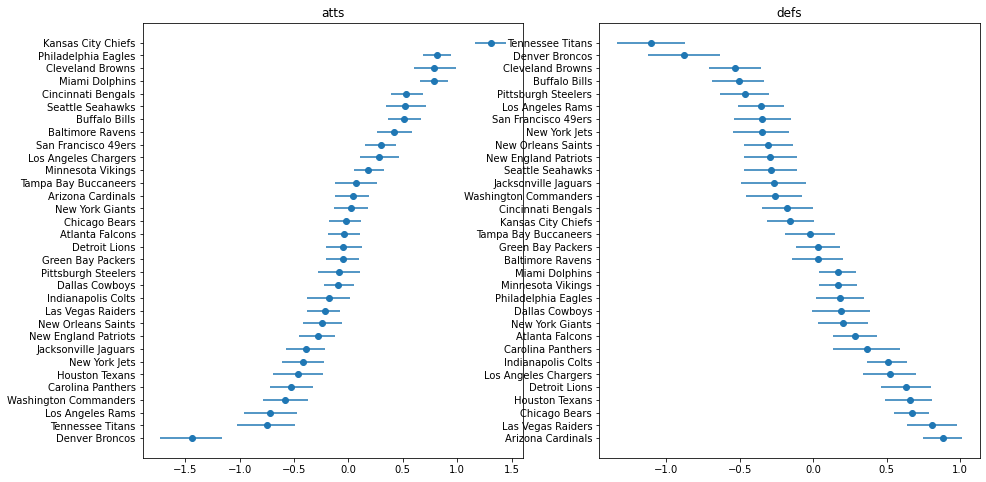

In [29]:
fig, axes  = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,8))
axes[0].errorbar(
    atts["median"],
    atts.index,
    xerr=(atts[["lower", "upper"]].values).T,
    fmt="o",
)
axes[0].set_title("atts")

axes[1].errorbar(
    defs["median"],
    defs.index,
    xerr=(defs[["lower", "upper"]].values).T,
    fmt="o",
)
axes[1].set_title("defs")
plt.show()

In [43]:
def goal_expectation(trace, home_team_id, away_team_id):   
    atts_home = np.mean([x[home_team_id] for x in trace["atts"]])
    atts_away = np.mean([x[away_team_id] for x in trace["atts"]])
    defs_home = np.mean([x[home_team_id] for x in trace["defs"]])
    defs_away = np.mean([x[away_team_id] for x in trace["defs"]])
    home = np.mean(trace["home"])

    home_theta = np.exp(atts_home + defs_away + home)
    away_theta = np.exp(atts_away + defs_home)

    return home_theta, away_theta

In [48]:
series = test.apply(lambda x: goal_expectation(trace, x.g1, x.g2), axis = 1)
test['team_home_pred'] = series.apply(lambda x:x[0])
test['team_away_pred'] = series.apply(lambda x:x[1])
test['team_home_win'] = test['yg1'].astype(int) > test['yg2'].astype(int)

In [49]:
test[["Date", "home_team", "away_team","yg1","yg2","team_home_pred","team_away_pred"]]

,Date,home_team,away_team,yg1,yg2,team_home_pred,team_away_pred
30,19/09/2022 23:15,Buffalo Bills,Tennessee Titans,41,7,10.998435,0.284669
124,06/11/2022 18:00,Atlanta Falcons,Los Angeles Chargers,17,20,32.362685,1.759325
196,11/12/2022 18:00,Buffalo Bills,New York Jets,20,12,23.461168,0.396621
127,06/11/2022 18:00,Detroit Lions,Green Bay Packers,15,9,19.656741,1.788561
216,18/12/2022 18:00,Jacksonville Jaguars,Dallas Cowboys,40,34,16.312742,0.696964
...,...,...,...,...,...,...,...
82,16/10/2022 17:00,Cleveland Browns,New England Patriots,15,38,32.600054,0.443397
113,30/10/2022 17:00,Minnesota Vikings,Arizona Cardinals,34,26,57.989528,1.230390
55,02/10/2022 17:00,Indianapolis Colts,Tennessee Titans,17,24,5.527361,0.782641
186,04/12/2022 18:00,Minnesota Vikings,New York Jets,27,22,16.928410,0.778899
